In [39]:
import pandas as pd
import warnings 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
warnings.filterwarnings('ignore')

In [40]:
data=pd.read_excel('name.xls')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False
data1 = data.drop(['土壤蒸发量(mm)','单日最大平均风速(knots)','平均风速(knots)','平均气温(℃)','平均气温≥18℃的天数','平均气温≤0℃的天数','径流量(m3)','最低海平面气压(hPa)','平均海平面气压(hPa)'],axis=1)

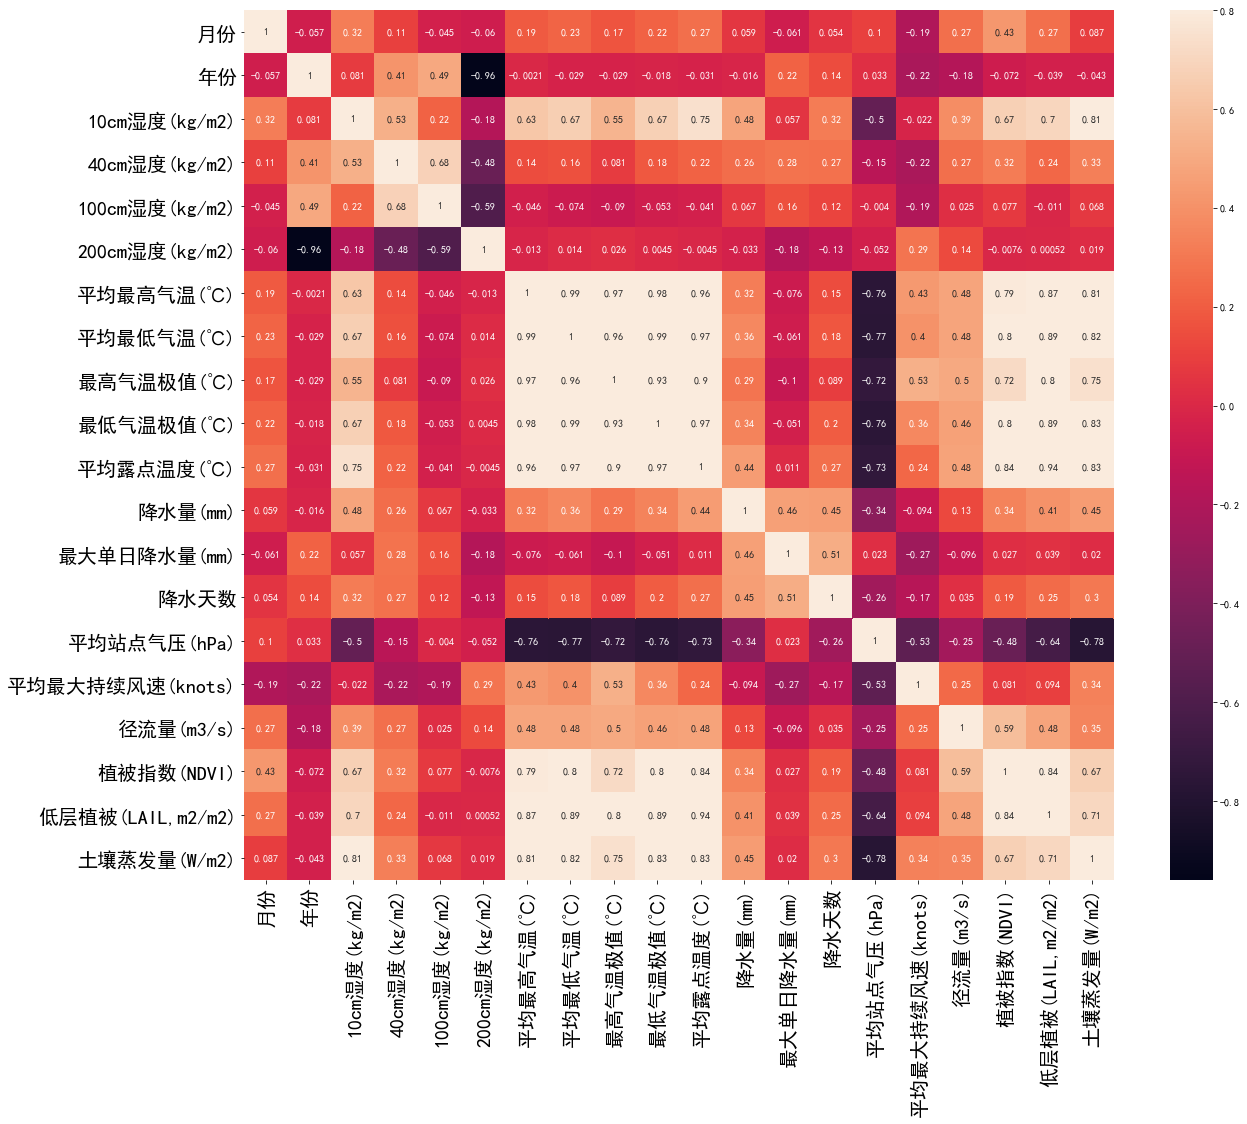

In [41]:
corr = data1.corr()
min_max_scaler = preprocessing.MinMaxScaler()
X_minMax = min_max_scaler.fit_transform(np.array(corr['10cm湿度(kg/m2)'][6:]).reshape(-1, 1))
spearman = []
for i in X_minMax:
    spearman.append(float(i / X_minMax.sum()))
ax = plt.subplots(figsize=(20, 16))#调整画布大小
ax = sns.heatmap(corr, vmax=.8, square=True, annot=True)#画热力图   annot=True 表示显示系数
# 设置刻度字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('spearman相关系数图')

In [42]:
X = data1.iloc[:,6:].values
y = data1['10cm湿度(kg/m2)'].values
warnings.filterwarnings('ignore')
def constant_feature_detect(data,threshold=0.98):
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = (data_copy[feature].value_counts() / np.float(len(data_copy))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),' variables are found to be almost constant') 
    print(quasi_constant_feature)
    return quasi_constant_feature
def distcorr(X, Y):
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor
rs = StandardScaler()
X = rs.fit_transform(X)
distcorr_list = []
for i in range(X.shape[1]):
    distcorr_list.append(distcorr(X[:,i],y))
distcorr_importance = np.abs(distcorr_list) / np.sum(np.abs(distcorr_list))
dist_corr_rank = np.argsort(-1 * distcorr_importance)
spearman_rank = np.argsort(-1 * np.array(spearman))
rfr = RandomForestRegressor(n_jobs=-1)
rfr.fit(X,y)
rf_importance = rfr.feature_importances_
rf_rank = np.argsort(-1 * rfr.feature_importances_)

en = ElasticNet(l1_ratio=0.00)
en.fit(X,y)
en_importance = np.abs(en.coef_) / np.sum(np.abs(en.coef_))
en_rank = np.argsort(-1 * abs(en.coef_))
# 
total_importance =0.5 * np.array(spearman)+ 0.2 * distcorr_importance + 0.1 * rf_importance + 0.1 * en_importance
total_importance = total_importance / total_importance.sum()
feature_rank = np.argsort(-1 * total_importance)

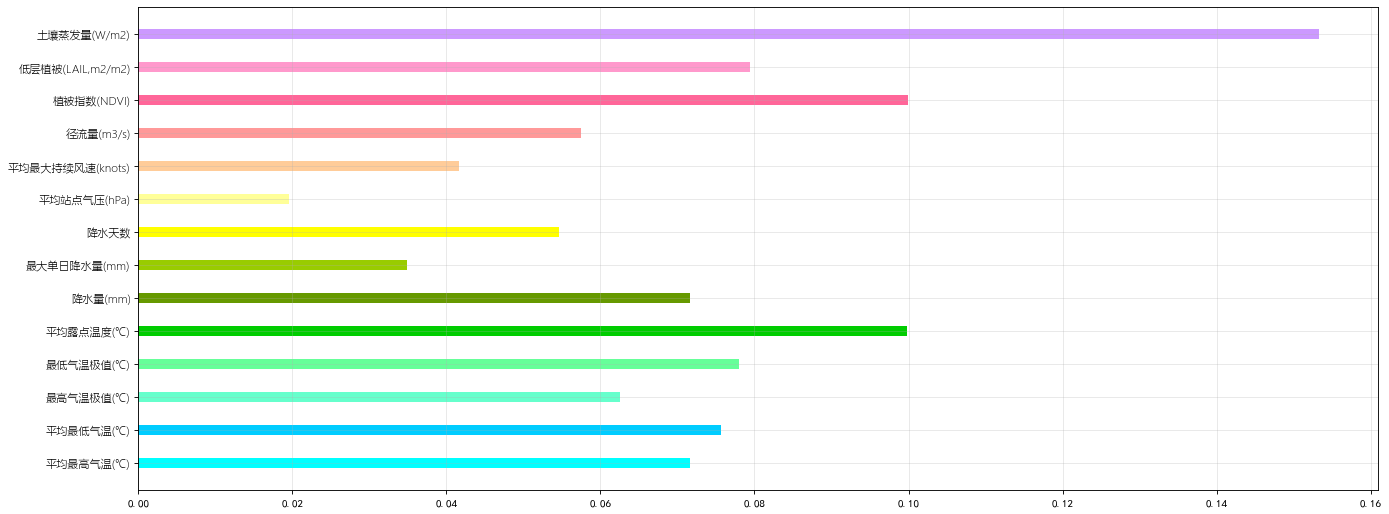

In [43]:
my_font = font_manager.FontProperties(fname="C:\Windows\Fonts\MSYHL.TTC")
col_name=data1.columns.values
a = col_name[6:]
b = total_importance
colorBuf = ['#00ffff','#00ccff','#66ffcc','#66ff99','#00cc00', '#669900','#99cc00','#ffff00','#ffff99','#ffcc99','#ff9999','#ff6699','#ff99cc','#cc99ff'] 
# 设置图像大小
plt.figure(figsize=(20,8),dpi=80)
# 绘制条形图
plt.barh(range(len(a)), b, height=0.3, color=colorBuf)  # 区别于竖的条形图 不能使用width
# 设置字符串到X轴
plt.yticks(range(len(a)), a, fontproperties=my_font)
plt.grid(alpha=0.3)
# plt.savefig('./movie.png')
plt.show()

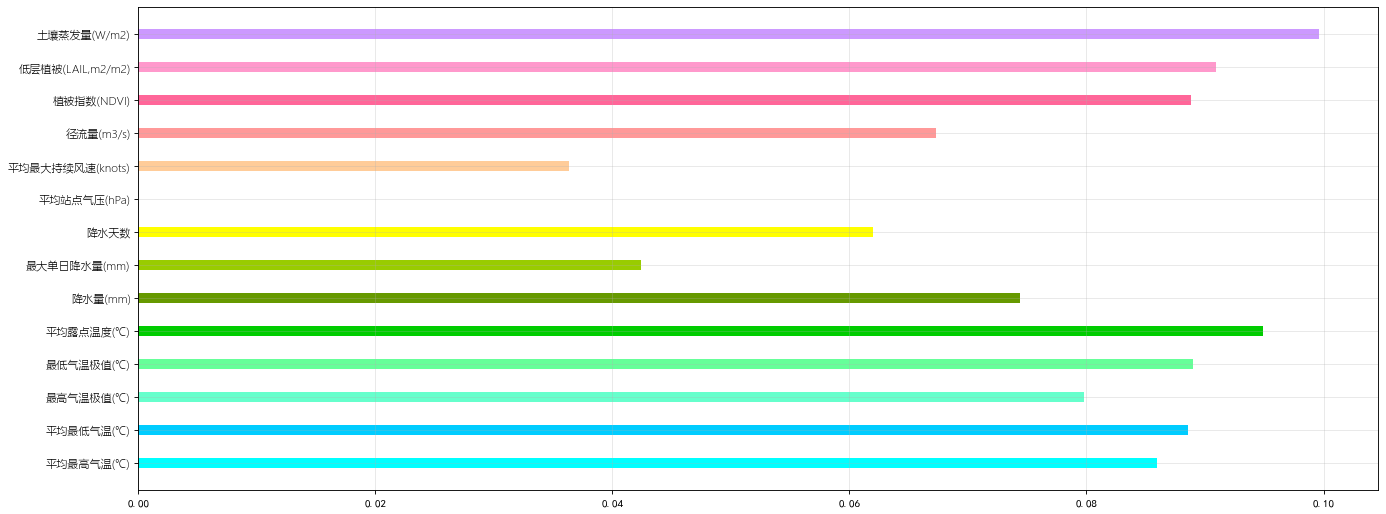

In [44]:
b = spearman
# 设置图像大小
plt.figure(figsize=(20,8),dpi=80)
# 绘制条形图
plt.barh(range(len(a)), b, height=0.3, color=colorBuf)  # 区别于竖的条形图 不能使用width
# 设置字符串到X轴
plt.yticks(range(len(a)), a, fontproperties=my_font)
plt.grid(alpha=0.3)
# plt.savefig('./movie.png')
plt.show()

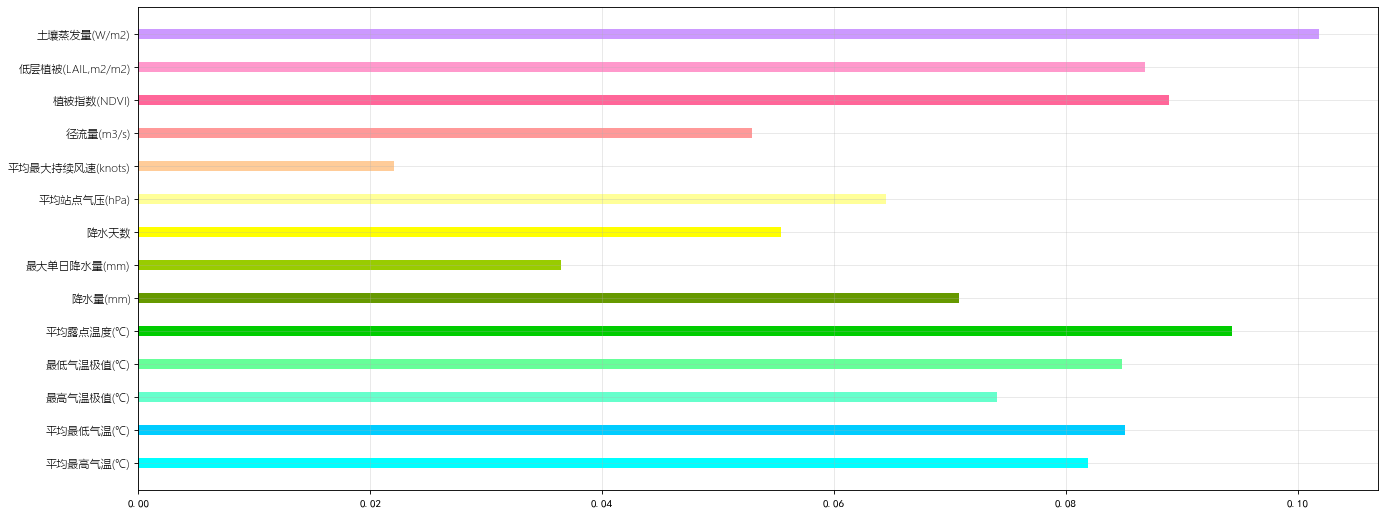

In [45]:
b = distcorr_importance
# 设置图像大小
plt.figure(figsize=(20,8),dpi=80)
# 绘制条形图
plt.barh(range(len(a)), b, height=0.3, color=colorBuf)  # 区别于竖的条形图 不能使用width
# 设置字符串到X轴
plt.yticks(range(len(a)), a, fontproperties=my_font)
plt.grid(alpha=0.3)
# plt.savefig('./movie.png')
plt.show()

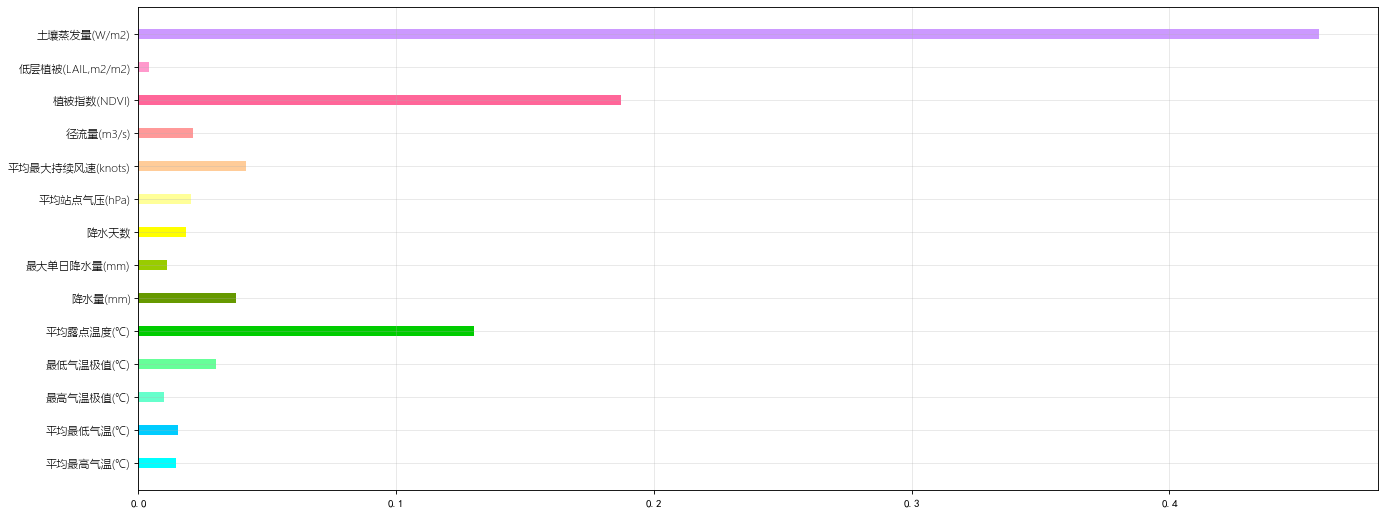

In [46]:
b = rf_importance
# 设置图像大小
plt.figure(figsize=(20,8),dpi=80)
# 绘制条形图
plt.barh(range(len(a)), b, height=0.3, color=colorBuf)  # 区别于竖的条形图 不能使用width
# 设置字符串到X轴
plt.yticks(range(len(a)), a, fontproperties=my_font)
plt.grid(alpha=0.3)
# plt.savefig('./movie.png')
plt.show()

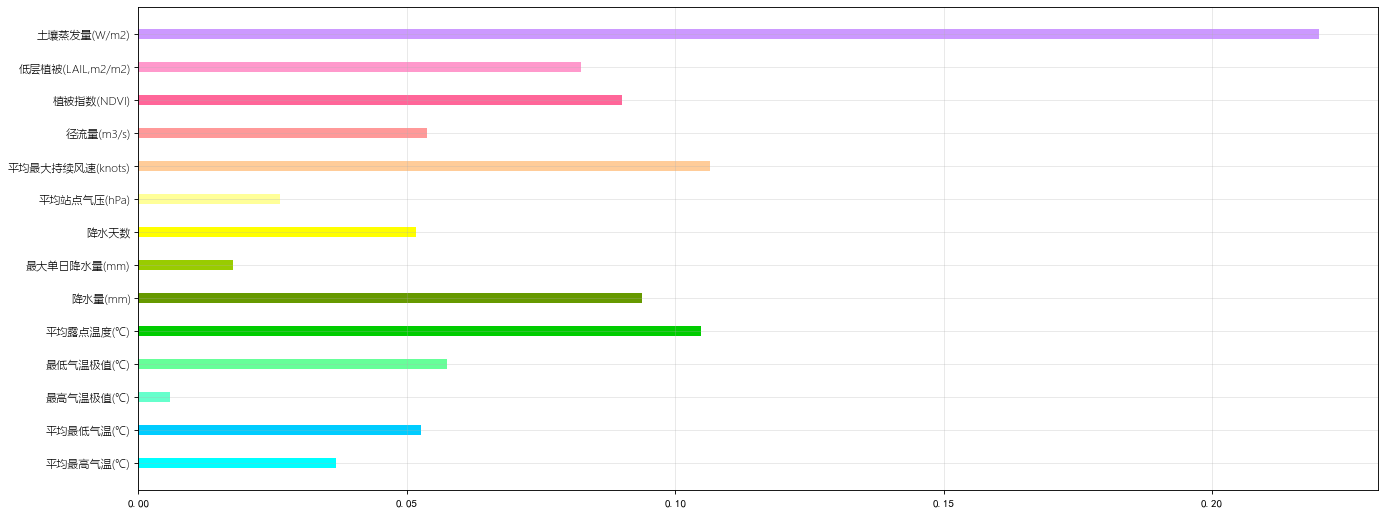

In [47]:

b = en_importance
# 设置图像大小
plt.figure(figsize=(20,8),dpi=80)
# 绘制条形图
plt.barh(range(len(a)), b, height=0.3, color=colorBuf)  # 区别于竖的条形图 不能使用width
# 设置字符串到X轴
plt.yticks(range(len(a)), a, fontproperties=my_font)
plt.grid(alpha=0.3)
# plt.savefig('./movie.png')
plt.show()

In [48]:
for i in feature_rank:
    print(col_name[6+i])
    print(total_importance[i])
    

土壤蒸发量(W/m2)
0.153350654204149
植被指数(NDVI)
0.09991704901423845
平均露点温度(℃)
0.09981323416939777
低层植被(LAIL,m2/m2)
0.07940851968789282
最低气温极值(℃)
0.07802795110768233
平均最低气温(℃)
0.07564365347546237
平均最高气温(℃)
0.07167109062945239
降水量(mm)
0.07163953856230579
最高气温极值(℃)
0.0625270220695337
径流量(m3/s)
0.05747931056982111
降水天数
0.05457005741288617
平均最大持续风速(knots)
0.04157126145304265
最大单日降水量(mm)
0.03487518906735269
平均站点气压(hPa)
0.019505468576782762
